In [92]:
import os
from typing import Optional
from pydantic import BaseModel, HttpUrl, ValidationError
from IPython.display import Image, display
from langgraph.graph import END, StateGraph
from langchain_community.document_loaders import SeleniumURLLoader
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain.prompts import PromptTemplate
from dotenv import load_dotenv

In [93]:
load_dotenv('../.env')  # Load environment variables

True

In [94]:
# ----------------------------
# State definition
# ----------------------------
class WebSearchState(BaseModel):
    url: Optional[HttpUrl] = None
    content: Optional[str] = None
    summary: Optional[str] = None

# Default URL to use initially
DEFAULT_URL = "https://www.mdpi.com/2076-3417/11/20/9772"

In [95]:
def search_node(state: WebSearchState) -> dict:
    # If URL already in state, summarize it first
    if state.url:
        print(f"[Search] Using existing URL: {state.url}")
        return {"url": str(state.url)}

    # Prompt user for URL with default shown
    user_input = input(f"🔗 Please enter a URL to summarize [default: {DEFAULT_URL}]: ").strip()
    url_input = user_input if user_input else DEFAULT_URL

    # Validate URL
    try:
        validated_state = WebSearchState(url=url_input)
    except ValidationError as e:
        raise ValueError(f"❌ Invalid URL: {e}")

    print(f"[Search] Using URL: {validated_state.url}")
    return {"url": str(validated_state.url)}

In [96]:
# ----------------------------
# 2. Load Webpage Node
# ----------------------------
def load_node(state: WebSearchState) -> dict:
    # Limit content length to ~100,000 characters (≈ 32,000 tokens max)
    MAX_CHARS = 30000
    url = state.url
    if not url:
        return {"content": "No URL to load"}
    loader = SeleniumURLLoader(urls=[str(url)])
    docs = loader.load()
    content = docs[0].page_content if docs else "No content loaded"
    # Truncate early to prevent overload later
    truncated_content = content[:MAX_CHARS]
    print(f"[Load] Loaded {len(truncated_content)} characters")
    return {"content": content}

In [97]:
# ----------------------------
# 3. Summarize Node
# ----------------------------
# loadding Huggingface token
HUGGINGFACEHUB_API_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")
repo_id = "mistralai/Mistral-7B-Instruct-v0.3"
model_kwargs = {"temperature": 0.1, 
                "max_new_tokens": 100, # Maximum tokens to generate
                "timeout": 6000}

llm = HuggingFaceEndpoint(
    repo_id=repo_id,
    huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN,
    **model_kwargs
)
chat_model = ChatHuggingFace(llm=llm)

WRITER_PROMPT = """
You are an expert summarizer with 20 years of experience.
Read the following webpage content 
carefully and produce a detailed 
but concise summary that captures key points clearly.

Webpage content:
{content}

Summary:
"""
prompt = PromptTemplate.from_template(WRITER_PROMPT)
summarize_chain = prompt | chat_model

def summarize_node(state: WebSearchState) -> dict:
    if not state.content:
        return {"summary": "No content to summarize"}
    result = summarize_chain.invoke({"content": state.content})
    result = result.content
    print("[Summarize] Done")
    # print(result)
    return {"summary": result}

In [98]:
# ----------------------------
# LangGraph Construction
# ----------------------------
builder = StateGraph(WebSearchState)
builder.add_node("search", search_node)
builder.add_node("load", load_node)
builder.add_node("summarize", summarize_node)

builder.set_entry_point("search")
builder.add_edge("search", "load")
builder.add_edge("load", "summarize")
builder.add_edge("summarize", END)

graph = builder.compile()

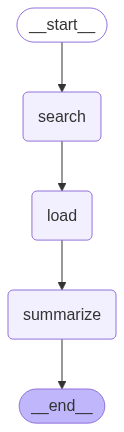

In [99]:
def graph_visualiser(graph):
    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except Exception as e:
        print(e)

graph_visualiser(graph=graph)

In [100]:
# ----------------------------
# Run It
# ----------------------------
# Run once with default URL to get initial summary
print("\n--- Generating summary for default URL ---")
initial_state = WebSearchState(url=DEFAULT_URL)
final_state = graph.invoke(initial_state)
final_state_model = WebSearchState.parse_obj(final_state)
print("\nURL:", final_state_model.url)
print("SUMMARY:\n", final_state_model.summary)


# Now prompt user to enter a new URL or leave blank to keep previous summary
while True:
    user_input = input("\nEnter a new URL to summarize or press Enter to exit: ").strip()
    if not user_input:
        print("Exiting. Goodbye!")
        break
    try:
        user_state = WebSearchState(url=user_input)
    except ValidationError as e:
        print(f"Invalid URL entered: {e}")
        continue

final_state = graph.invoke(user_state)
final_state_model = WebSearchState.parse_obj(final_state)
print("\nURL:", final_state_model.url)
print("SUMMARY:\n", final_state_model.summary)


--- Generating summary for default URL ---
[Search] Using existing URL: https://www.mdpi.com/2076-3417/11/20/9772
[Load] Loaded 30000 characters


C:\Users\DANNY\AppData\Local\Temp\ipykernel_9704\1414824205.py:8: PydanticDeprecatedSince20: The `parse_obj` method is deprecated; use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  final_state_model = WebSearchState.parse_obj(final_state)


[Summarize] Done

URL: https://www.mdpi.com/2076-3417/11/20/9772
SUMMARY:
  The article discusses the design of a gas cyclone using a hybrid particle swarm optimization (PSO) algorithm. The research aims to simplify complex mathematical models and the sensitivity approach for gas cyclone design with the use of an objective function, which is of the minimization type. The process makes use of the initial population generated by the DE algorithm, and the stopping criterion of DE is set as the fitness value. When the fitness value is not less than the current global best, the DE population is taken over by PSO. For each iteration, the new velocity and position are updated in every generation until the optimal solution is achieved. The hybrid DEPSO method first reduces the search space using the DE algorithm, and then the obtained populations are used as the initial population by the PSO to achieve a fast convergence rate to a final global optimum. The proposed DEPSO method is compared to 

HfHubHTTPError: 402 Client Error: Payment Required for url: https://router.huggingface.co/together/v1/chat/completions (Request ID: Root=1-686fdd94-63190e1c129ec1a04138b33e;4cdc7b66-a1fe-4e32-901f-ee8dc7eb98c7)

You have exceeded your monthly included credits for Inference Providers. Subscribe to PRO to get 20x more monthly included credits.